In [5]:
import json

def load_data(path):
    data = None
    with open(path, 'r') as openfile:
        data = json.load(openfile)
    return data

def group_by_algo_and_mnum(data:dict):
    out = {}
    for k, v in data.items():
        curr = {}
        for exp in v:
            machine_num = exp['setup']['machine_num']
            machine_no = exp['setup']['machine_no']
            if machine_num not in curr.keys():
                curr[machine_num] = [
                    {
                        'machine_no': machine_no,
                        'data': exp['data']
                    }
                ]
            else:
                curr[machine_num].append({
                        'machine_no': machine_no,
                        'data': exp['data']
                    })
        out[k] = curr
    return out

data = load_data('cpu_data.json')
data = group_by_algo_and_mnum(data)

In [6]:
import re

def parse_top_time(time:str):
    match = re.search("(\d+):(\d+)\.(\d+)", time)
    if match is None:
        print("Error parsing {}".format(time))
        return None
    minutes = int(match.group(1))
    sec = int(match.group(2))
    hsec = float(match.group(3))/100.0
    return minutes*60+sec+round(hsec)

def process_one_exp_data(exp_data:list):
    """
    exp_data should look like:
        ['14318 165.0 0:04.95 kcore_simple', ...]
    """
    processed_row = {}
    for row in exp_data:
        entries = row.split(" ")
        pid, cpu, time, _ = entries
        time = parse_top_time(time)
        if pid not in processed_row.keys():
            processed_row[pid] = {
                "time": [i for i in range(time)],
                "cpu": [cpu for i in range(time)]
            }
        else:
            last_time = -1 if len(processed_row[pid]['time']) == 0 else processed_row[pid]['time'][-1]
            processed_row[pid]['time'] += [i for i in range(last_time+1, last_time+time+1)]
            processed_row[pid]['cpu'] += [cpu for i in range(time)]
    return processed_row

tmp = process_one_exp_data(data['kcore'][1][0]['data'])

190.0
136.7
140.8
189.3
154.3
179.7
178.7
182.7
164.0
158.0
Saving to cpu/kcore/1_machine_num.png
Saving to cpu/kcore/2_machine_num.png
Saving to cpu/kcore/3_machine_num.png
Saving to cpu/kcore/4_machine_num.png
176.7
400.0
262.7
245.3
209.0
254.0
400.0
244.7
275.0
211.5
Saving to cpu/pagerank/1_machine_num.png
Saving to cpu/pagerank/2_machine_num.png
Saving to cpu/pagerank/3_machine_num.png
Saving to cpu/pagerank/4_machine_num.png


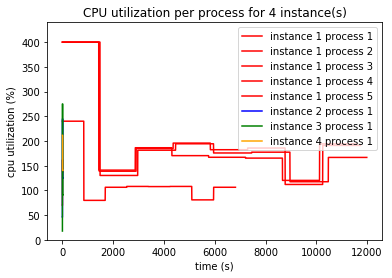

In [8]:
import matplotlib.pyplot as plt
import os

from pathlib import Path
%matplotlib inline

def compute_y_max(grouped_exp_data):
    """
    grouped_exp_data should look like:
        {
            1: [
                {'machine_num':1, 'data':[..]}, 
                ...
            ],
            ...
        }
    """
    ret = 0
    for k, v in grouped_exp_data.items():
        for one_exp in v:
            tmp = process_one_exp_data(one_exp['data'])
            curr_max = __compute_y_max(tmp)
            if curr_max > ret:
                ret = curr_max
    return ret
    

def __compute_y_max(grouped_exp_data):
    """
    grouped_exp_data should look like:
        {
            '14318':{
                'time':[...],
                'cpu':[...]
            },
            ...
        }
    """
    ret = 0.0
    for k, v in grouped_exp_data.items():
        data = [float(i) for i in v['cpu']]
        curr_max = max(data)
        if curr_max > ret:
            ret = curr_max
    print(ret)
    return ret


def plot_one_exp_data(grouped_exp_data:dict, y_max=400, legend_prefix="", color='blue'):
    """
    grouped_exp_data should look like:
        {
            '14318':{
                'time':[...],
                'cpu':[...]
            },
            ...
        }
    """
    process_count = 0

    for k, v in grouped_exp_data.items():
        process_count += 1
        label = "{}process {}".format(legend_prefix, process_count)
        x = v['time']
        y = v['cpu']
        y = [float(i) for i in y]
        plt.plot(x, y, label=label, color=color)
        axes = plt.gca()
        axes.set_ylim([0,y_max])
    return

def plot_one_exp_group_by_mnum(grouped_exp_data:list, title, y_max):
    """
    grouped_exp_data should look like:
        [
            {'machine_num':1, 'data':[..]}, 
            ...
        ]
    """
    plt.clf()
    colors = ['red', 'blue', 'green', 'orange']
    for count, one_exp in enumerate(grouped_exp_data):
        tmp = process_one_exp_data(one_exp['data'])
        plot_one_exp_data(
            tmp, y_max=y_max*1.1,
            legend_prefix='instance {} '.format(count+1), 
            color=colors[count])
    plt.xlabel("time (s)")
    plt.ylabel('cpu utilization (%)')
    plt.legend()
    plt.title(title)
    #plt.show()
    return

def plot_one_exp_group_by_algo(grouped_exp_data:dict, algo:str):
    """
    grouped_exp_data should look like:
        {
            1: [
                {'machine_num':1, 'data':[..]}, 
                ...
            ],
            ...
        }
    """
    y_max = compute_y_max(grouped_exp_data)
    for k, v in grouped_exp_data.items():
        title = "CPU utilization per process for {} instance(s)".format(k)
        plot_one_exp_group_by_mnum(v, title, y_max)
        save_fig(f'cpu/{algo}/{k}_machine_num.png')
    return

def save_fig(path):
    print(f"Saving to {path}")
    Path(os.path.dirname(path)).mkdir(parents=True, exist_ok=True)
    plt.savefig(path, bbox_inches='tight')
    return

"""
Plot and saves
"""
def plot_all(grouped_data:dict):
    for k, v in grouped_data.items():
        plot_one_exp_group_by_algo(v, k)
    return

#plot_one_exp_data(tmp, legend_prefix='instance 1 ')
#plot_one_exp_group_by_mnum(data['kcore'][1])
#plot_one_exp_group_by_algo(data['kcore'])
plot_all(data)